<a href="https://colab.research.google.com/github/trandangtrungduc/BasicMachineLearningTask/blob/main/Watson_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **TABLE OF CONTENTS**

---

## 1. Exploratory Data Analysis and Pre-process data

## 2. Sequence to sequence Model

## 3. Bert Model






---


## **1. Exploratory Data Analysis and Pre-process data** 




### 1.1 Import necessary librabries

In [ ]:
from google.colab import drive # Mount drive to google colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import string
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from gensim.models import word2vec
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

!pip install transformers
from transformers import BertTokenizer, TFBertModel, AutoTokenizer, TFXLMRobertaModel
os.environ["WANDB_API_KEY"] = "0" # No warning

# !pip install git+https://github.com/BoseCorp/py-googletrans.git --upgrade
# !pip install googletrans==4.0.0-rc1
# pip install google_trans_new
# from google_trans_new import google_translator
# !pip install translate
# from translate import Translator
# from googletrans import Translator

In [ ]:
# Initialization with TPU
try:
  TPU = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(TPU)
  tf.tpu.experimental.initialize_tpu_system(TPU)
  strategy= tf.distribute.experimental.TPUStrategy(TPU)
except ValueError:
  strategy = tf.distribute.get_strategy()
  

In [ ]:
# Import data from google drive
train = pd.read_csv("drive/MyDrive/Data/train.csv")
test = pd.read_csv("drive/MyDrive/Data/test.csv")

### 1.2 Exploratory Data Analysis

In [ ]:
train.head(3)

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0


In [ ]:
# Check missing values and duplicate values
print(train.isnull().sum())
train.drop_duplicates() 
print('----------------------')
print(test.isnull().sum())
test.drop_duplicates() 

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64
----------------------
id            0
premise       0
hypothesis    0
lang_abv      0
language      0
dtype: int64


,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian
...,...,...,...,...,...
5190,5f90dd59b0,نیند نے وعدہ کیا کہ موٹل نے سوال میں تحقیق کی.,نیمیتھ کو موٹل کی تفتیش کے لئے معاوضہ دیا جارہ...,ur,Urdu
5191,f357a04e86,The rock has a soft texture and can be bough...,The rock is harder than most types of rock.,en,English
5192,1f0ea92118,她目前的存在，并考虑到他与沃佛斯顿争执的本质，那是尴尬的。,她在与Wolverstone的打斗结束后才在场的事实被看作是很尴尬的。,zh,Chinese
5193,0407b48afb,isn't it i can remember i've only been here ei...,I could see downtown Dallas from where I lived...,en,English


In [ ]:
# Example of a sample
print("Premise: " + train.premise.values[0])
print("Hypothesis: " + train.hypothesis.values[0])
print("Label: " + 'entailment' if train.label.values[0] == 0 else 'contradiction' if train.label.values[0] == 2 else 'neutral')

Premise: and these comments were considered in formulating the interim rules.
Hypothesis: The rules developed in the interim were put together with these comments in mind.
Label: entailment


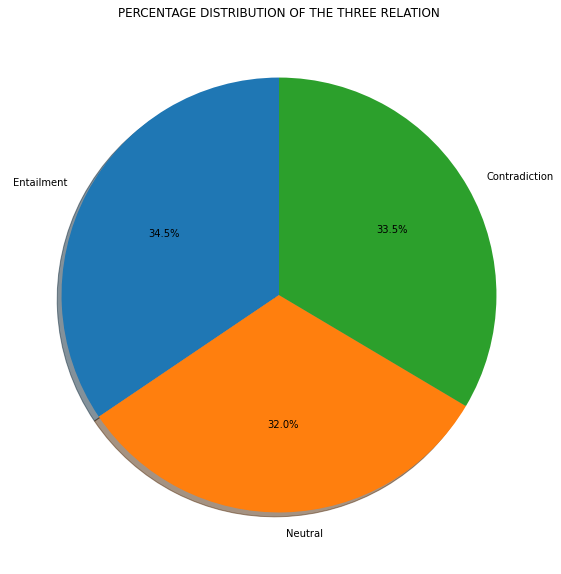

In [ ]:
# Label distribution in the data
relation, frequencies = np.unique(train.label.values, return_counts = True)
relation = np.where(relation == 0, 'Entailment', relation)
relation = np.where(relation == '1', 'Neutral', relation)
relation = np.where(relation == '2', 'Contradiction', relation)
plt.figure(figsize=(10,10))
plt.pie(frequencies, labels=relation, autopct='%1.1f%%', shadow = True, startangle = 90)
plt.title('PERCENTAGE DISTRIBUTION OF THE THREE RELATION')
plt.show()

> Three labels are distributed according to the number of samples of the data.

> This is a balance data.




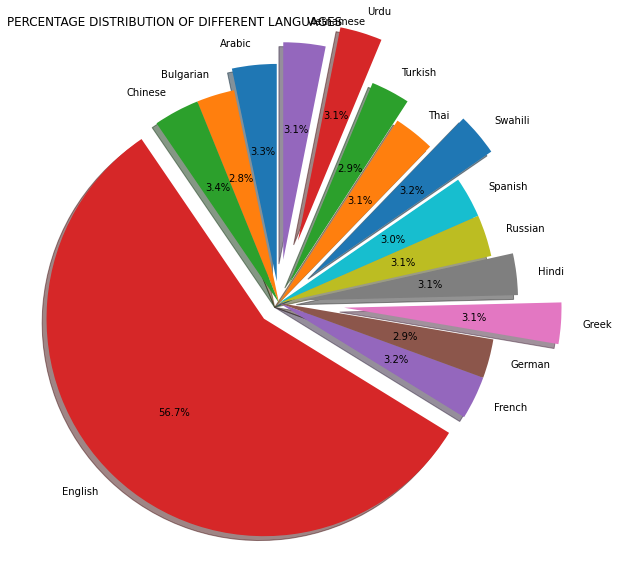

In [ ]:
# Language distribution in the data
labels, frequencies = np.unique(train.language.values, return_counts = True)
plt.figure(figsize=(10,10))
explode = (0.1, 0, 0, 0.1, 0, 0, 0.3, 0.1, 0, 0, 0.2, 0, 0.1, 0.3, 0.2) 
plt.pie(frequencies, labels = labels, explode=explode, autopct='%1.1f%%', shadow = True, startangle = 90)
plt.title('PERCENTAGE DISTRIBUTION OF DIFFERENT LANGUAGES', loc='left')
plt.show()

> The data uses mainly English (greater than 50%).

> The other 14 languages are equally divided (about 3% each language).




In [ ]:
Basic_statistic = pd.DataFrame()
# Number of words in a sample
Basic_statistic['Word_of_Pre_Sam']  = train.premise.apply(lambda NumOfWord: len(NumOfWord.split()))
Basic_statistic['Word_of_Hypo_Sam'] = train.hypothesis.apply(lambda NumOfWord: len(NumOfWord.split()))
# Number of characters in a sample
Basic_statistic['Char_of_Pre_Sam']  = train.premise.apply(lambda NumOfChar: len(str(NumOfChar)))
Basic_statistic['Char_of_Hypo_Sam'] = train.hypothesis.apply(lambda NumOfChar: len(str(NumOfChar)))
# Number of punctuations in a sample
Basic_statistic['Punc_of_Pre_Sam']  = train.premise.apply(lambda NumOfPunc: len([punc for punc in NumOfPunc if punc in string.punctuation]))
Basic_statistic['Punc_of_Hypo_Sam'] = train.hypothesis.apply(lambda NumOfPunc: len([punc for punc in NumOfPunc if punc in string.punctuation]))
# Number of sentences in a sample
Basic_statistic['Sen_of_Pre_Sam']  = train.premise.apply(lambda NumOfSen: len([dots for dots in NumOfSen if dots == '.']))
Basic_statistic['Sen_of_Hypo_Sam'] = train.hypothesis.apply(lambda NumOfSen: len([dots for dots in NumOfSen if dots == '.']))
Basic_statistic['Sen_of_Pre_Sam']  = Basic_statistic.Sen_of_Pre_Sam.apply(lambda x: 1 if x == 0 else x)
Basic_statistic['Sen_of_Hypo_Sam'] = Basic_statistic.Sen_of_Hypo_Sam.apply(lambda x: 1 if x == 0 else x)
# Average length of the words
Basic_statistic['Avg_of_Pre_Word']  = train.premise.apply(lambda AvgOfWord: np.mean([len(word) for word in AvgOfWord.split()]))
Basic_statistic['Avg_of_Hypo_Word'] = train.hypothesis.apply(lambda AvgOfWord: np.mean([len(word) for word in AvgOfWord.split()]))

Basic_statistic['label'] = train.label
Basic_statistic.head(5)

,Word_of_Pre_Sam,Word_of_Hypo_Sam,Char_of_Pre_Sam,Char_of_Hypo_Sam,Punc_of_Pre_Sam,Punc_of_Hypo_Sam,Sen_of_Pre_Sam,Sen_of_Hypo_Sam,Avg_of_Pre_Word,Avg_of_Hypo_Word,label
0,10,14,68,81,1,1,1,1,5.900000,4.857143,0
1,15,10,81,58,2,1,1,1,4.400000,4.900000,2
2,15,4,92,37,3,3,1,1,5.200000,8.500000,0
3,17,8,92,50,1,2,1,1,4.470588,5.375000,0
4,6,1,182,47,0,0,1,1,29.500000,47.000000,1


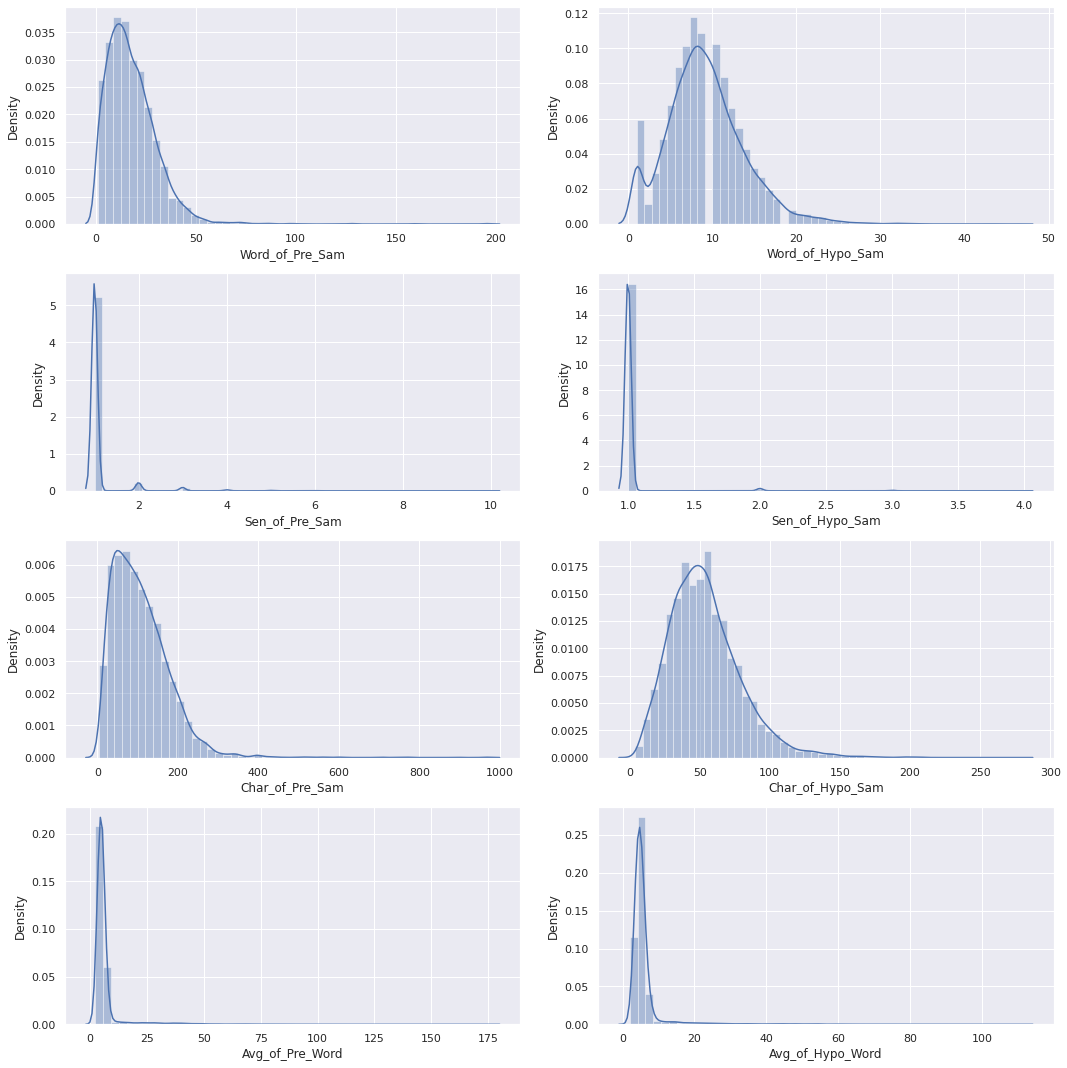

In [ ]:
# Distribution diagram of some basic statistics
sns.set_theme(style="darkgrid", palette="deep") 
list_feature_number=['Word_of_Pre_Sam', 'Word_of_Hypo_Sam',
                     'Sen_of_Pre_Sam', 'Sen_of_Hypo_Sam',
                     'Char_of_Pre_Sam', 'Char_of_Hypo_Sam',
                     'Avg_of_Pre_Word', 'Avg_of_Hypo_Word'] 
fig, ax = plt.subplots(4,2, figsize=(15,15)) 
i = 0 
for x in range(4):
    for y in range(2):
        sns.distplot(Basic_statistic[list_feature_number[i]], ax = ax[x,y])
        i += 1
plt.tight_layout() 
plt.show()

> All distributions is skewed to the left.

> All distributions that are not normally distributed.

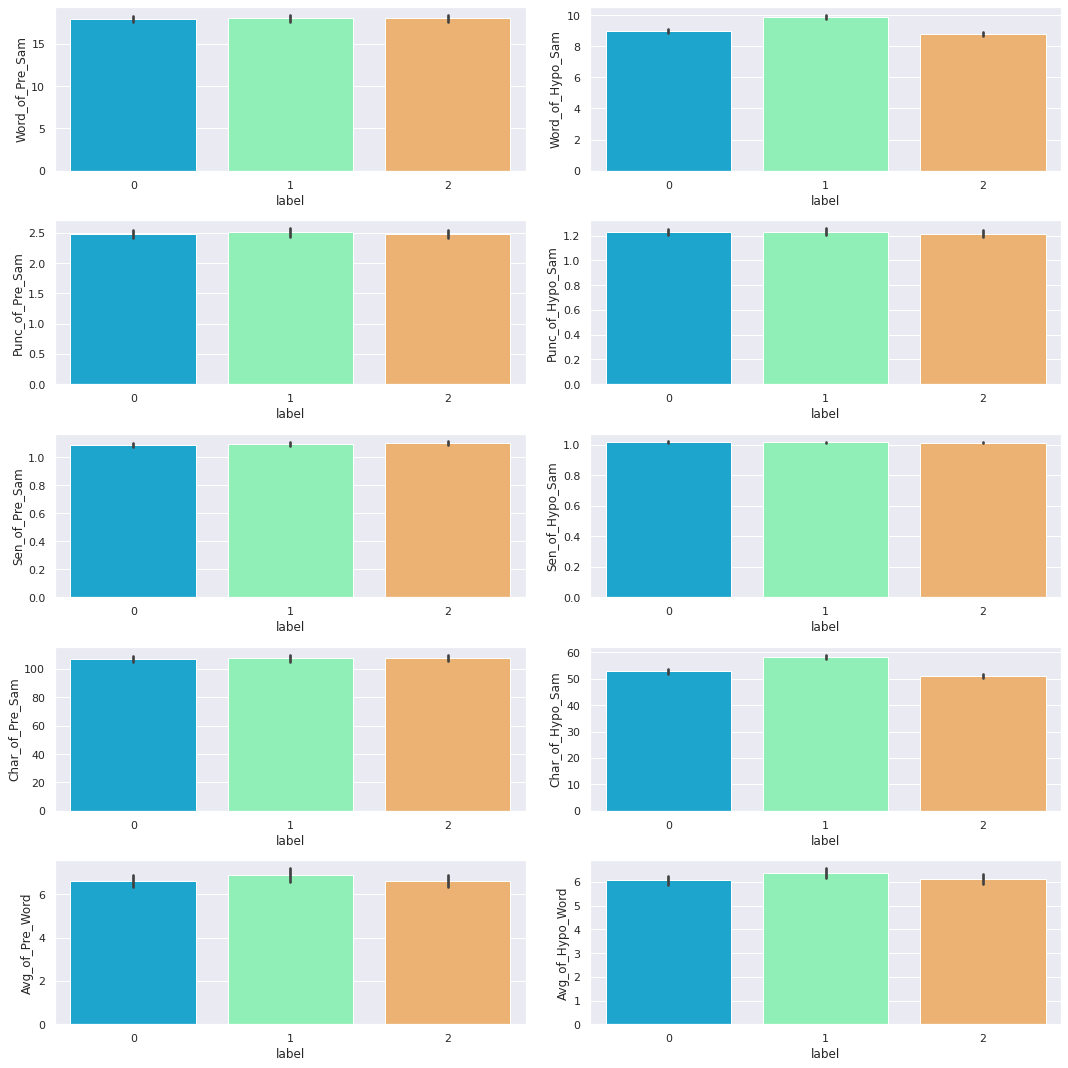

In [ ]:
# Distribution diagram of some basic statistics according to labels
list_feature_number=['Word_of_Pre_Sam', 'Word_of_Hypo_Sam',
                     'Punc_of_Pre_Sam', 'Punc_of_Hypo_Sam',
                     'Sen_of_Pre_Sam',  'Sen_of_Hypo_Sam',
                     'Char_of_Pre_Sam', 'Char_of_Hypo_Sam',
                     'Avg_of_Pre_Word', 'Avg_of_Hypo_Word'] 
fig, ax = plt.subplots(5,2, figsize=(15,15)) 
i = 0 
for x in range(5):
    for y in range(2):
        sns.barplot(Basic_statistic.label,Basic_statistic[list_feature_number[i]], ax = ax[x,y], palette='rainbow')
        i += 1
plt.tight_layout() 
plt.show()

> Words, punctuation marks, characters are distributed according to 3 labels.



In [ ]:
# Function supports word translation 
def Translation(text):
  translator = Translator(to_lang='it')
  return translator.translate(text)
train.premise[train.lang_abv != 'en'] = train.premise[train.lang_abv != 'en'].apply(lambda x: Translation(x))
train.hypothesis[train.lang_abv != 'en'] = train.hypothesis[train.lang_abv != 'en'].apply(lambda x: Translation(x))
test.premise[test.lang_abv != 'en'] = test.premise[test.lang_abv != 'en'].apply(lambda x: Translation(x))
test.hypothesis[test.lang_abv != 'en'] = test.hypothesis[test.lang_abv != 'en'].apply(lambda x: Translation(x))
train.to_csv("drive/MyDrive/Data/train_english_translated.csv")
test.to_csv("drive/MyDrive/Data/test_english_translated.csv")

---


## **2. Sequence to sequence** 

In [ ]:
train_translated = pd.read_csv("drive/MyDrive/Data/train_english_translated.csv")
test_translated = pd.read_csv("drive/MyDrive/Data/test_english_translated.csv")

In [ ]:
train_translated.tail(4)

,id,premise,hypothesis,lang_abv,language,label
12116,31f0c3d2d3,C R functions can also be evaluated with or wi...,C R functions can be evaluated in different wa...,el,Greek,1
12117,39ea2c1e23,"design, draw and sew by hand all of these gorg...",The costumes were only worked by human hands.,fr,French,1
12118,30a3361a15,We didn't know what U2 U2 was and nobody knew ...,We did not know the name of what we saw in the...,ur,Urdu,1
12119,be162b40cc,"Last year, more than 48,000 abused and neglect...",The majority of the abused and neglected child...,th,Thai,1


In [ ]:
nltk.download('stopwords')
Stop_words = set(stopwords.words('english'))
def cleaner(text):
  newText = text.lower()
  newText = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", newText)
  newText = re.sub('"','', newText)
  newText = re.sub(r"'s\b","", newText)
  newText = re.sub("[^a-zA-Z]", " ", newText)
  tokens = [word for word in newText.split() if word not in Stop_words]
  long_words = []
  for i in tokens:
    if len(i) >= 3:
      long_words.append(i)
  return (" ".join(long_words)).strip()

def clean_apply(series):
  cleaned_text = []
  for text in series:
    cleaned_text.append(cleaner(text))
  return cleaned_text

train_translated['cleaned_premise'] = clean_apply(train_translated['premise'])
train_translated['cleaned_hypothesis'] = clean_apply(train_translated['hypothesis'])
test_translated['cleaned_premise'] = clean_apply(test_translated['premise'])
test_translated['cleaned_hypothesis'] = clean_apply(test_translated['hypothesis'])

In [ ]:
def tagger(decoder_input_sentence):
  bos = "<BOS> "
  eos = " <EOS>"
  final_target = [bos + text + eos for text in decoder_input_sentence] 
  return final_target

def vocab_creater(text_lists, VOCAB_SIZE):

  tokenizer = Tokenizer(num_words=VOCAB_SIZE)
  tokenizer.fit_on_texts(text_lists)
  dictionary = tokenizer.word_index
  
  word2idx = {}
  idx2word = {}
  for k, v in dictionary.items():
      if v < VOCAB_SIZE:
          word2idx[k] = v
          idx2word[v] = k
      if v >= VOCAB_SIZE-1:
          continue         
  return word2idx, idx2word

VOCAB_SIZE = 14999
def text2seq(encoder_text, decoder_text, VOCAB_SIZE):
  tokenizer = Tokenizer(num_words=VOCAB_SIZE)
  tokenizer.fit_on_texts(encoder_text)
  decoder_sequences = tokenizer.texts_to_sequences(decoder_text)
  encoder_sequences = tokenizer.texts_to_sequences(encoder_text)
  return encoder_sequences,decoder_sequences

def padding(encoder_sequences, decoder_sequences, MAX_LEN):   
  encoder_input_data = pad_sequences(encoder_sequences, maxlen=MAX_LEN, dtype='int32', padding='post', truncating='post')
  decoder_input_data = pad_sequences(decoder_sequences, maxlen=MAX_LEN, dtype='int32', padding='post', truncating='post') 
  return encoder_input_data, decoder_input_data

def glove_100d_dictionary(GLOVE_DIR):
  embeddings_index = {}
  f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
  f.close()
  return embeddings_index

def embedding_matrix_creater(embedding_dimention):
  embedding_matrix = np.zeros((len(word_index) + 1, embedding_dimention))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector
  return embedding_matrix

def embedding_layer_creater(VOCAB_SIZE, EMBEDDING_DIM, MAX_LEN, embedding_matrix):
  
  embedding_layer = tf.keras.layers.Embedding(input_dim = VOCAB_SIZE, 
                              output_dim = EMBEDDING_DIM,
                              input_length = MAX_LEN,
                              weights = [embedding_matrix],
                              trainable = False)
  return embedding_layer

def decoder_output_creater(decoder_input_data, num_samples, MAX_LEN, VOCAB_SIZE):
  
  decoder_output_data = np.zeros((num_samples, MAX_LEN, VOCAB_SIZE), dtype="float32")

  for i, seqs in enumerate(decoder_input_data):
      for j, seq in enumerate(seqs):
          if j > 0:
              decoder_output_data[i][j][seq] = 1.
  print(decoder_output_data.shape)
  
  return decoder_output_data

def data_spliter(encoder_input_data, decoder_input_data, test_size1=0.2, test_size2=0.3):
  
  en_train, en_test, de_train, de_test = train_test_split(encoder_input_data, decoder_input_data, test_size=test_size1)
  en_train, en_val, de_train, de_val = train_test_split(en_train, de_train, test_size=test_size2)
  
  return en_train, en_val, en_test, de_train, de_val, de_test

In [ ]:
train_translated['cleaned_premise'] = tagger(train_translated['cleaned_premise'].tolist())
train_translated['cleaned_hypothesis'] = tagger(train_translated['cleaned_hypothesis'].tolist())

In [ ]:
EMBEDDING_DIM = 100
MAX_LEN = 10
VOCAB_SIZE = 11000
num_samples = len(encoder_sequences)

In [ ]:
word_index, idx2word = vocab_creater(text_lists=train_translated['cleaned_hypothesis']+train_translated['cleaned_premise'], VOCAB_SIZE=11000)
encoder_sequences, decoder_sequences = text2seq(train_translated['cleaned_premise'], train_translated['cleaned_hypothesis'], VOCAB_SIZE) 
encoder_input_data, decoder_input_data = padding(encoder_sequences, decoder_sequences, MAX_LEN=10)
embeddings_index = glove_100d_dictionary('drive/MyDrive/Data/')
embedding_matrix = embedding_matrix_creater(EMBEDDING_DIM)
embedding_layer = embedding_layer_creater(VOCAB_SIZE, EMBEDDING_DIM, MAX_LEN, embedding_matrix)
en_train, en_val, en_test, de_train, de_val, de_test = data_spliter(encoder_input_data, decoder_input_data)

In [ ]:
encoder_sequences

[[1, 776, 580, 5844, 3094, 516, 2],
 [1, 456, 5845, 581, 1034, 139, 2043, 14, 2],
 [1, 3, 21, 3095, 5, 1086, 1624, 49, 441, 3, 7, 2],
 [1, 8164, 87, 8165, 900, 2],
 [1, 89, 2465, 30, 1351, 28, 1146, 2],
 [1, 16, 486, 11446, 309, 2735, 4, 1530, 3096, 2],
 [1, 39, 608, 53, 679, 5846, 110, 2],
 [1, 76, 2736, 196, 4865, 76, 50, 2466, 4865, 3, 160, 1889, 8166, 109, 2],
 [1,
  1206,
  11447,
  11448,
  986,
  4100,
  3097,
  8167,
  11449,
  4866,
  6,
  5847,
  2044,
  2045,
  2],
 [1, 249, 8168, 734, 416, 8169, 84, 487, 417, 777, 8170, 1147, 4101, 4102, 2],
 [1,
  457,
  237,
  293,
  2046,
  8,
  2235,
  735,
  150,
  1035,
  1352,
  488,
  2046,
  126,
  901,
  735,
  987,
  213,
  12,
  3517,
  430,
  214,
  250,
  2],
 [1, 944, 2],
 [1,
  1207,
  93,
  986,
  8171,
  2737,
  2467,
  354,
  902,
  53,
  5848,
  1890,
  8172,
  637,
  4103,
  582,
  654,
  8173,
  8174,
  2738,
  379,
  680,
  4104,
  4105,
  65,
  242,
  1531,
  2],
 [1, 8175, 2047, 4867, 2],
 [1, 8176, 2],
 [1, 380, 23

In [ ]:
print(encoder_input_data.shape)
encoder_input_data

(12120, 10)


array([[   1,  776,  580, ...,    0,    0,    0],
       [   1,  456, 5845, ...,   14,    2,    0],
       [   1,    3,   21, ...,   49,  441,    3],
       ...,
       [   1,  422, 4661, ...,  348, 4099, 1303],
       [   1,    3, 1237, ...,    0,    0,    0],
       [   1,   48,   19, ...,   95,   33, 3891]], dtype=int32)

In [ ]:
decoder_output_data = decoder_output_creater(decoder_input_data, num_samples, MAX_LEN, VOCAB_SIZE)

(12120, 10, 12000)


In [ ]:
en_train.shape

(6787, 10)

In [ ]:
def seq2seq_model_builder(HIDDEN_DIM=20):

    encoder_inputs = tf.keras.Input(shape=(MAX_LEN, ), dtype='int32',)
    encoder_embedding = embedding_layer(encoder_inputs)
    encoder_LSTM = tf.keras.layers.LSTM(HIDDEN_DIM, return_state=True)
    encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)
    
    decoder_inputs =  tf.keras.Input(shape=(MAX_LEN, ), dtype='int32',)
    decoder_embedding = embedding_layer(decoder_inputs)
    decoder_LSTM = tf.keras.layers.LSTM(HIDDEN_DIM, return_state=True, return_sequences=True)
    decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=[state_h, state_c])
    
    # dense_layer = Dense(VOCAB_SIZE, activation='softmax')
    outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(VOCAB_SIZE, activation='softmax'))(decoder_outputs)
    model = tf.keras.Model([encoder_inputs, decoder_inputs], outputs)
    
    return model

In [ ]:
model = seq2seq_model_builder(HIDDEN_DIM=300)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 10, 100)      1100000     input_23[0][0]                   
                                                                 input_24[0][0]                   
__________________________________________________________________________________________________
lstm_14 (LSTM)                  [(None, 300), (None, 481200      embedding_6[4][0]          

---


## **3. Bert Model** 

### 3.1 Tokenize and Configure for Bert model

In [ ]:
# Import translated datas
train_translated = pd.read_csv("drive/MyDrive/Data/train_english_translated.csv")
test_translated = pd.read_csv("drive/MyDrive/Data/test_english_translated.csv")

In [ ]:
''' Initialize pretrained Bert models '''
''' Models are used to tokenize and configure '''
# pretrained_model = "bert-base-cased" 
# pretrained_model = "bert-base-multilingual-cased"
# pretrained_model = "bert-large-cased"

''' Models are used to configure with "bert-large-cased" tokenization '''
# pretrained_model = "roberta-base"
# pretrained_model = "roberta-large"
pretrained_model = "jplu/tf-xlm-roberta-base"
# Tokenizer = BertTokenizer.from_pretrained(pretrained_model)

In [ ]:
# Function supports sentence tokenization
def encode_for_sentence(sentence):
  tokens = list(Tokenizer.tokenize(sentence))
  tokens.append('[SEP]')
  return Tokenizer.convert_tokens_to_ids(tokens)

> BERT uses three kind of input data- input word IDs, input masks, and input type IDs.

> We add a [CLS] token to denote the beginning of the inputs, and a [SEP] token to denote the separation between the premise and the hypothesis. We also need to pad all of the inputs to be the same size.

In [ ]:
# Function supports configure
def config_input(tokenizer, premise, hypothesis, max_seq_length):

  sentence_premise    = tf.ragged.constant([encode_for_sentence(sentence) for sentence in premise])
  sentence_hypothesis = tf.ragged.constant([encode_for_sentence(sentence) for sentence in hypothesis])
  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence_hypothesis.shape[0]
  
  input_word_ids = tf.concat([cls, sentence_hypothesis, sentence_premise], axis=-1)
  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))
  type_cls, type_sen_hypo, type_sen_pre = tf.zeros_like(cls), tf.zeros_like(sentence_hypothesis), tf.ones_like(sentence_premise)
  input_type_ids = tf.concat([type_cls, type_sen_hypo, type_sen_pre], axis=-1).to_tensor(shape=(None, max_seq_length))
  input = {'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)), 'input_mask': input_mask, 'input_type_ids': input_type_ids}

  return input

In [ ]:
# Apply configure
MAX_SEQUENCE_LENGTH = 115
train_config = config_input(Tokenizer, train_translated.cleaned_premise.values, train_translated.cleaned_hypothesis.values, MAX_SEQUENCE_LENGTH)
test_config = config_input(Tokenizer, test_translated.cleaned_premise.values, test_translated.cleaned_hypothesis.values, MAX_SEQUENCE_LENGTH)

In [ ]:
# Function supports model building
def build_model():
    config_input = TFBertModel.from_pretrained(pretrained_model)
    input_word_ids = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="input_type_ids")
    
    embedding = config_input([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
# Function supports plotting
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc)+1)

  plt. figure(figsize=(20,8))
  plt.subplot(1,2,1)
  plt.grid(color='g', linestyle='-', linewidth=1)
  plt.plot(x, acc, 'b', label='Training Accuracy')
  plt.plot(x, val_acc, 'r', label='Validation Accuracy')
  plt.title('TRANING AND VALIDATION ACCURACY')
  plt.legend()
  plt.subplot(1,2,2)
  plt.grid(color='g', linestyle='-', linewidth=1)
  plt.plot(x, loss, 'b', label='Training Loss')
  plt.plot(x, val_loss, 'r', label='Training Loss')
  plt.title('TRAINING AND VALIDATION LOSS')
  plt.legend()

### 3.2 Model 1 with pretrained "bert-base-cased"

In [ ]:
# Compile and summarize
with strategy.scope():
    model = build_model()
    model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 115)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 115)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 115)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 108310272   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


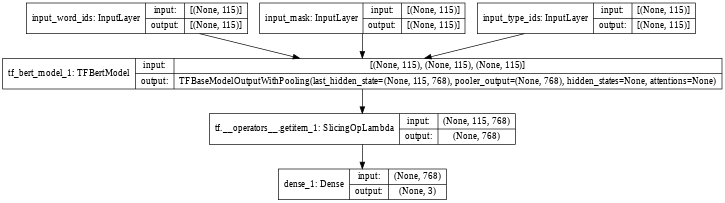

In [ ]:
# Visualize model struture
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [ ]:
# Train
History = model.fit(train_config, train_translated.label.values, epochs = 10, verbose = 1, batch_size = 64, validation_split = 0.2)

Epoch 1/10
152/152 [==============================] - 16s 105ms/step - loss: 0.9748 - accuracy: 0.5211 - val_loss: 0.9912 - val_accuracy: 0.5140
Epoch 2/10
152/152 [==============================] - 16s 105ms/step - loss: 0.8737 - accuracy: 0.5989 - val_loss: 0.9973 - val_accuracy: 0.5297
Epoch 3/10
152/152 [==============================] - 16s 105ms/step - loss: 0.7758 - accuracy: 0.6568 - val_loss: 1.0270 - val_accuracy: 0.5318
Epoch 4/10
152/152 [==============================] - 16s 105ms/step - loss: 0.6377 - accuracy: 0.7359 - val_loss: 1.1242 - val_accuracy: 0.5215
Epoch 5/10
152/152 [==============================] - 16s 105ms/step - loss: 0.5154 - accuracy: 0.7929 - val_loss: 1.3099 - val_accuracy: 0.5161
Epoch 6/10
152/152 [==============================] - 16s 105ms/step - loss: 0.3862 - accuracy: 0.8444 - val_loss: 1.4964 - val_accuracy: 0.5165
Epoch 7/10
152/152 [==============================] - 16s 105ms/step - loss: 0.2889 - accuracy: 0.8867 - val_loss: 1.6892 - val_ac

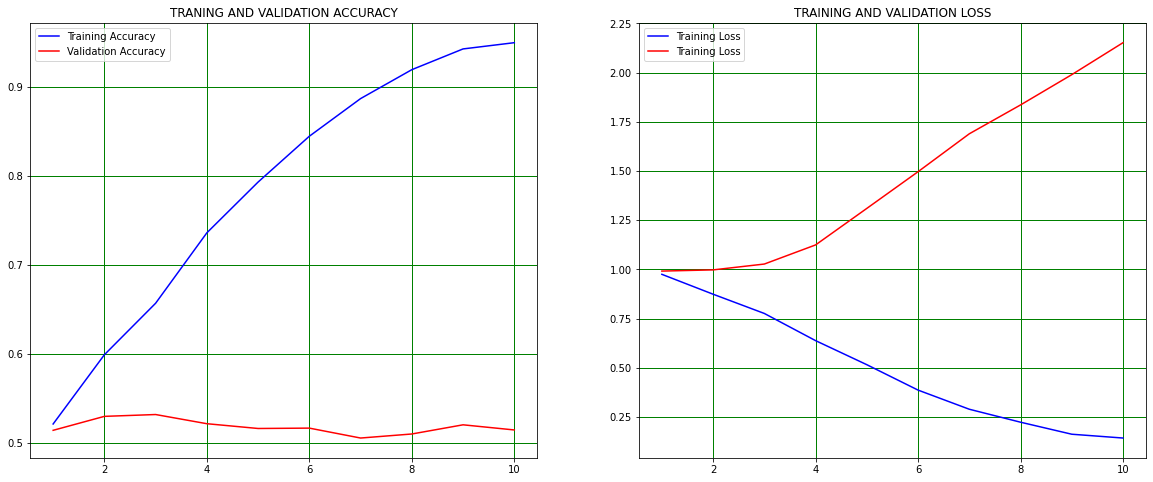

In [ ]:
plot_history(History)

In [ ]:
# Predict test set
predictions = [np.argmax(i) for i in model.predict(test_config)]
test_translated['prediction'] = predictions
test_translated = test_translated.drop(columns=['lang_abv', 'language','cleaned_premise', 'cleaned_hypothesis'])
test_translated.head()

,id,premise,hypothesis,prediction
0,aa2510d454,His family had lost a son and a daughter now.,The son and daughter had lost their father.,0
1,865d1c7b16,Steps are initiated to allow program board mem...,There's enough room for 35-40 positions on the...,1
2,6d9fa191e6,"agencies' operating trust, enterprise and inte...",Agencies in financial trouble are usually audi...,1
3,f11f1ffffe,how long has he been in his present position,What length of time has he held the current po...,2
4,40a9b0f08e,Research and development is composed of,R&D is made up of.,0


> **Conclusion:**

> The model has high accuracy (95%), but the accuracy of the validation set is almost constant.

> Loss of train set decreases but validation set increases.

### 3.3 Model 2 with pretrained "bert-base-multilingual-cased"

In [ ]:
# Compile and summarize
with strategy.scope():
    model = build_model()
    model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 115)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 115)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 115)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 177853440   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
152/152 [==============================] - 18s 121ms/step - loss: 0.9221 - accuracy: 0.5638 - val_loss: 0.9370 - val_accuracy: 0.5446
Epoch 2/10
152/152 [==============================] - 19s 125ms/step - loss: 0.8296 - accuracy: 0.6305 - val_loss: 0.9698 - val_accuracy: 0.5462
Epoch 3/10
152/152 [==============================] - 18s 122ms/step - loss: 0.7335 - accuracy: 0.6772 - val_loss: 1.0580 - val_accuracy: 0.5041
Epoch 4/10
152/152 [==============================] - 19s 122ms/step - loss: 0.6263 - accuracy: 0.7330 - val_loss: 1.1340 - val_accuracy: 0.5301
Epoch 5/10
152/152 [==============================] - 19s 122ms/step - loss: 0.5105 - accuracy: 0.7857 - val_loss: 1.3005 - val_accuracy: 0.5380
Epoch 6/10
152/152 [==============================] - 18s 122ms/step - loss: 0.4200 - accuracy: 0.8270 - val_loss: 1.4600 - val_accuracy: 0.5330
Epoch 7/10
152/152 [==============================] - 19s 124ms/step - loss: 0.3532 - accuracy: 0.8590 - val_loss: 1.5777 - val_ac

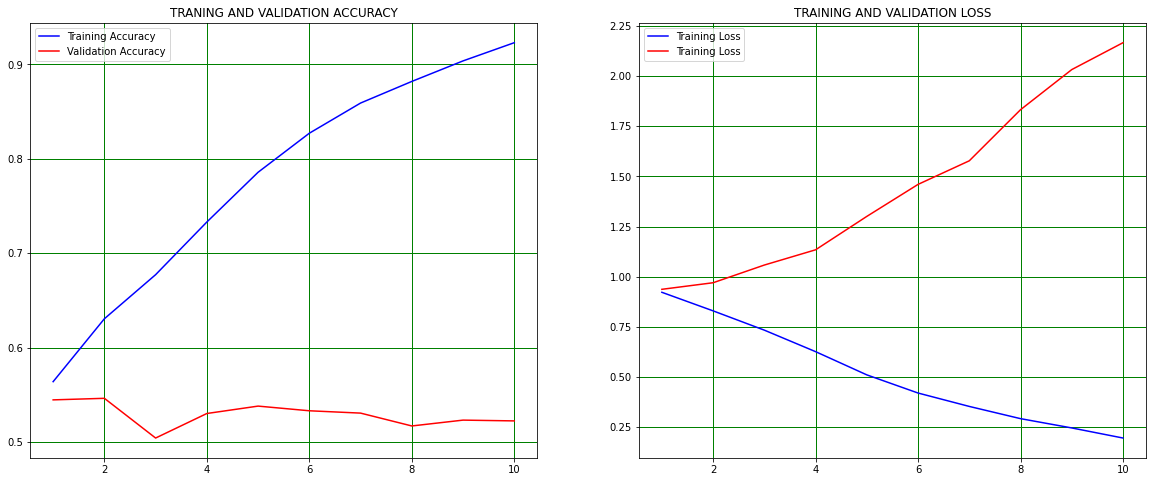

In [ ]:
# Train and visualize
History = model.fit(train_config, train_translated.label.values, epochs = 10, verbose = 1, batch_size = 64, validation_split = 0.2)
plot_history(History)

In [ ]:
# Predict test set
predictions = [np.argmax(i) for i in model.predict(test_config)]
test_translated['prediction'] = predictions
test_translated = test_translated.drop(columns=['lang_abv', 'language','cleaned_premise', 'cleaned_hypothesis'])
test_translated.head()

,id,premise,hypothesis,prediction
0,aa2510d454,His family had lost a son and a daughter now.,The son and daughter had lost their father.,1
1,865d1c7b16,Steps are initiated to allow program board mem...,There's enough room for 35-40 positions on the...,1
2,6d9fa191e6,"agencies' operating trust, enterprise and inte...",Agencies in financial trouble are usually audi...,1
3,f11f1ffffe,how long has he been in his present position,What length of time has he held the current po...,0
4,40a9b0f08e,Research and development is composed of,R&D is made up of.,0


> **Conclusion:**

> The model has high accuracy (92%), but the accuracy of the validation set is almost constant.

> Loss of train set decreases but validation set increases.

### 3.4 Model 3 with pretrained "bert-large-cased"

In [ ]:
# Compile and summarize
with strategy.scope():
    model = build_model()
    model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 115)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 115)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 115)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 333579264   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
152/152 [==============================] - 40s 266ms/step - loss: 1.0591 - accuracy: 0.4501 - val_loss: 1.0196 - val_accuracy: 0.4856
Epoch 2/10
152/152 [==============================] - 40s 266ms/step - loss: 0.9805 - accuracy: 0.5208 - val_loss: 0.9720 - val_accuracy: 0.5338
Epoch 3/10
152/152 [==============================] - 40s 266ms/step - loss: 0.9166 - accuracy: 0.5658 - val_loss: 0.9465 - val_accuracy: 0.5606
Epoch 4/10
152/152 [==============================] - 40s 266ms/step - loss: 0.8363 - accuracy: 0.6224 - val_loss: 0.9466 - val_accuracy: 0.5627
Epoch 5/10
152/152 [==============================] - 40s 266ms/step - loss: 0.7409 - accuracy: 0.6779 - val_loss: 1.0281 - val_accuracy: 0.5586
Epoch 6/10
152/152 [==============================] - 41s 267ms/step - loss: 0.6364 - accuracy: 0.7337 - val_loss: 1.0613 - val_accuracy: 0.5565
Epoch 7/10
152/152 [==============================] - 41s 267ms/step - loss: 0.5200 - accuracy: 0.7860 - val_loss: 1.3032 - val_ac

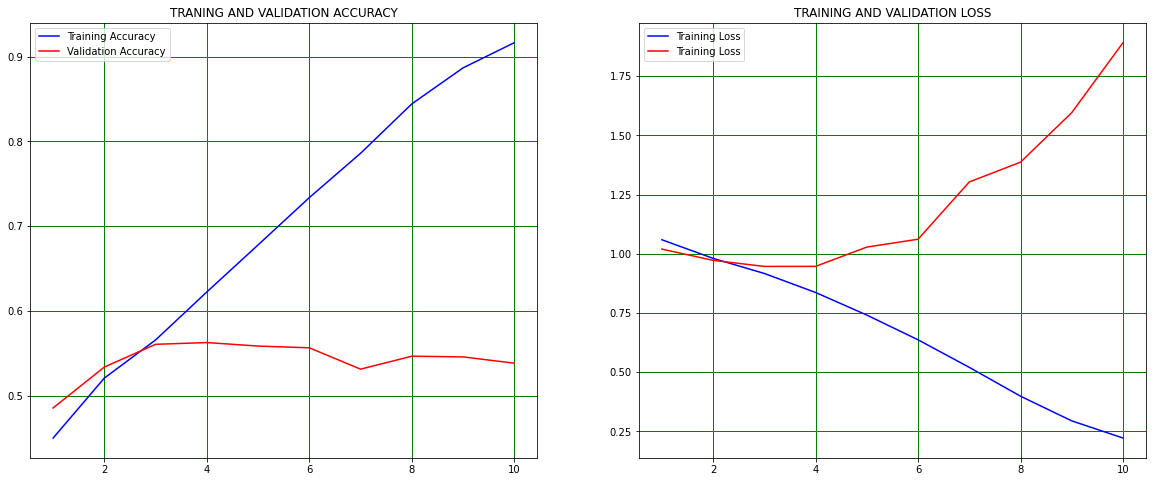

In [ ]:
# Train and visualize
History = model.fit(train_config, train_translated.label.values, epochs = 10, verbose = 1, batch_size = 64, validation_split = 0.2)
plot_history(History)

In [ ]:
# Predict test set
predictions = [np.argmax(i) for i in model.predict(test_config)]
test_translated['prediction'] = predictions
test_translated = test_translated.drop(columns=['lang_abv', 'language','cleaned_premise', 'cleaned_hypothesis'])
test_translated.head()

,id,premise,hypothesis,prediction
0,aa2510d454,His family had lost a son and a daughter now.,The son and daughter had lost their father.,0
1,865d1c7b16,Steps are initiated to allow program board mem...,There's enough room for 35-40 positions on the...,1
2,6d9fa191e6,"agencies' operating trust, enterprise and inte...",Agencies in financial trouble are usually audi...,1
3,f11f1ffffe,how long has he been in his present position,What length of time has he held the current po...,0
4,40a9b0f08e,Research and development is composed of,R&D is made up of.,0


> **Conclusion:**

> The model has high accuracy (92%), but the accuracy of the validation set is almost constant.

> Loss of train set decreases but validation set increases.

### 3.5 Model 4 with pretrained "roberta-base"

In [ ]:
# Compile and summarize
with strategy.scope():
    model = build_model()
    model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 115)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 115)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 115)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 333579264   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
152/152 [==============================] - 40s 266ms/step - loss: 0.9450 - accuracy: 0.5437 - val_loss: 0.9409 - val_accuracy: 0.5536
Epoch 2/10
152/152 [==============================] - 40s 266ms/step - loss: 0.8134 - accuracy: 0.6301 - val_loss: 0.9764 - val_accuracy: 0.5557
Epoch 3/10
152/152 [==============================] - 40s 266ms/step - loss: 0.6585 - accuracy: 0.7165 - val_loss: 1.1048 - val_accuracy: 0.5590
Epoch 4/10
152/152 [==============================] - 41s 271ms/step - loss: 0.4763 - accuracy: 0.8022 - val_loss: 1.3069 - val_accuracy: 0.5441
Epoch 5/10
152/152 [==============================] - 40s 266ms/step - loss: 0.3407 - accuracy: 0.8691 - val_loss: 1.5469 - val_accuracy: 0.5487
Epoch 6/10
152/152 [==============================] - 41s 267ms/step - loss: 0.2443 - accuracy: 0.9059 - val_loss: 1.7253 - val_accuracy: 0.5454
Epoch 7/10
152/152 [==============================] - 40s 266ms/step - loss: 0.1750 - accuracy: 0.9336 - val_loss: 1.8582 - val_ac

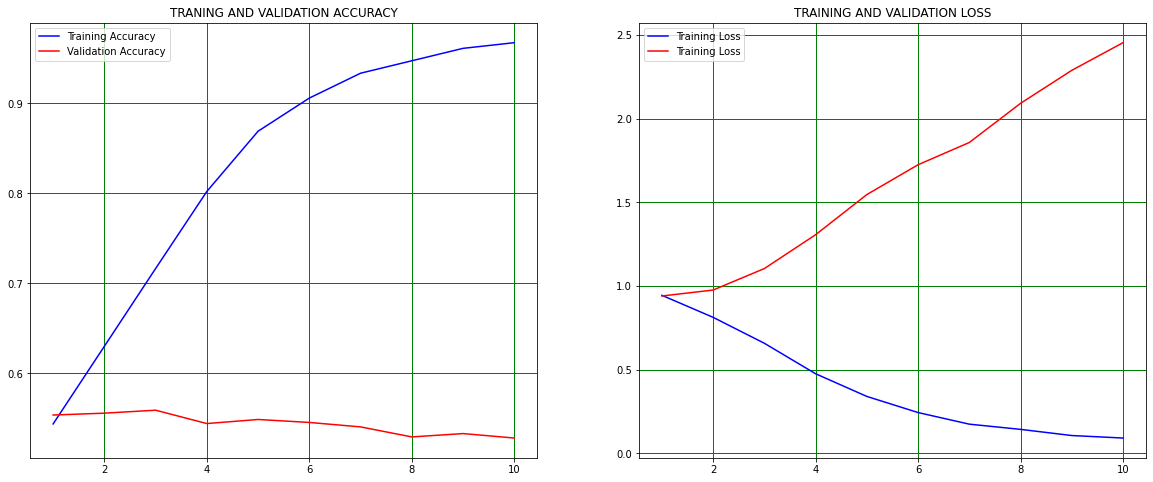

In [ ]:
# Train and visualize
History = model.fit(train_config, train_translated.label.values, epochs = 10, verbose = 1, batch_size = 64, validation_split = 0.2)
plot_history(History)

In [ ]:
# Predict test set
predictions = [np.argmax(i) for i in model.predict(test_config)]
test_translated['prediction'] = predictions
test_translated = test_translated.drop(columns=['lang_abv', 'language','cleaned_premise', 'cleaned_hypothesis'])
test_translated.head()

,id,premise,hypothesis,prediction
0,aa2510d454,His family had lost a son and a daughter now.,The son and daughter had lost their father.,0
1,865d1c7b16,Steps are initiated to allow program board mem...,There's enough room for 35-40 positions on the...,1
2,6d9fa191e6,"agencies' operating trust, enterprise and inte...",Agencies in financial trouble are usually audi...,1
3,f11f1ffffe,how long has he been in his present position,What length of time has he held the current po...,0
4,40a9b0f08e,Research and development is composed of,R&D is made up of.,0


> **Conclusion:**

> The model has high accuracy (97%), but the accuracy of the validation set is almost constant.

> Loss of train set decreases but validation set increases.

### 3.6 Model 5 with pretrained "roberta-large"

In [ ]:
# Compile and summarize
with strategy.scope():
    model = build_model()
    model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 115)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 115)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 115)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 355359744   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

Epoch 1/15
152/152 [==============================] - 41s 273ms/step - loss: 1.1574 - accuracy: 0.3295 - val_loss: 1.1092 - val_accuracy: 0.3251
Epoch 2/15
152/152 [==============================] - 42s 275ms/step - loss: 1.1344 - accuracy: 0.3428 - val_loss: 1.0996 - val_accuracy: 0.3375
Epoch 3/15
152/152 [==============================] - 42s 274ms/step - loss: 1.1366 - accuracy: 0.3348 - val_loss: 1.1901 - val_accuracy: 0.3251
Epoch 4/15
152/152 [==============================] - 41s 273ms/step - loss: 1.1325 - accuracy: 0.3366 - val_loss: 1.0979 - val_accuracy: 0.3399
Epoch 5/15
152/152 [==============================] - 42s 273ms/step - loss: 1.1282 - accuracy: 0.3351 - val_loss: 1.1115 - val_accuracy: 0.3445
Epoch 6/15
152/152 [==============================] - 42s 274ms/step - loss: 1.1170 - accuracy: 0.3499 - val_loss: 1.1302 - val_accuracy: 0.3375
Epoch 7/15
152/152 [==============================] - 42s 274ms/step - loss: 1.1115 - accuracy: 0.3638 - val_loss: 1.1246 - val_ac

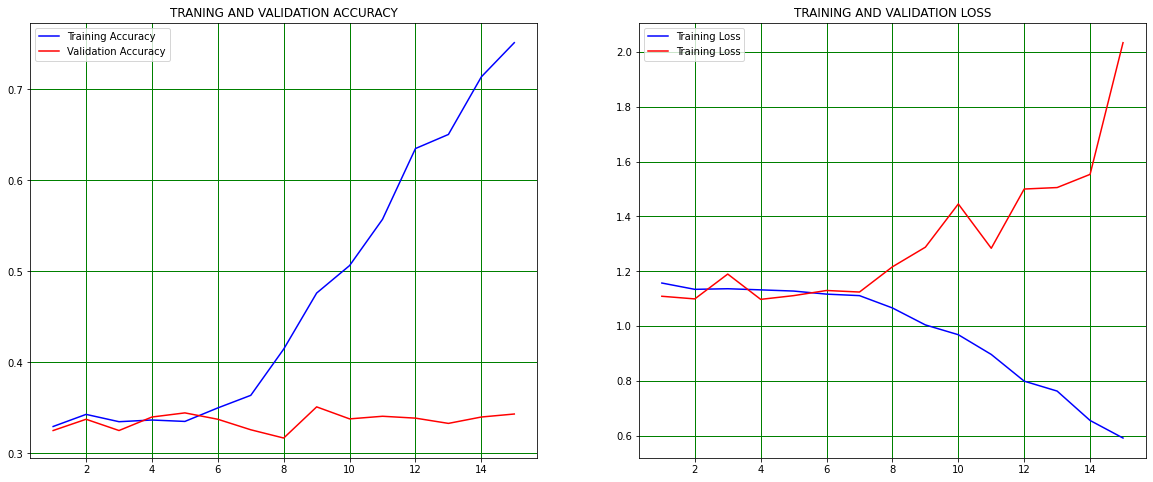

In [ ]:
# Train and visualize
History = model.fit(train_config, train_translated.label.values, epochs = 15, verbose = 1, batch_size = 64, validation_split = 0.2)
plot_history(History)

In [ ]:
# Predict test set
predictions = [np.argmax(i) for i in model.predict(test_config)]
test_translated = test_translated.drop(columns=['lang_abv', 'language','cleaned_premise', 'cleaned_hypothesis'])
test_translated['prediction'] = predictions
test_translated.head()

,id,premise,hypothesis,prediction
0,aa2510d454,His family had lost a son and a daughter now.,The son and daughter had lost their father.,2
1,865d1c7b16,Steps are initiated to allow program board mem...,There's enough room for 35-40 positions on the...,2
2,6d9fa191e6,"agencies' operating trust, enterprise and inte...",Agencies in financial trouble are usually audi...,0
3,f11f1ffffe,how long has he been in his present position,What length of time has he held the current po...,2
4,40a9b0f08e,Research and development is composed of,R&D is made up of.,0


> **Conclusion:**

> The model has quite low accuracy (75%), the accuracy of the validation very low (34%).

> Loss of train set decreases but validation set increases.

### 3.7 Model 6 with pretrained "jplu/tf-xlm-roberta-base"

In [ ]:
# Compile and summarize
with strategy.scope():
    model = build_model()
    model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 115)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 115)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 115)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 278043648   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/15
152/152 [==============================] - 22s 144ms/step - loss: 0.5802 - accuracy: 0.7531 - val_loss: 1.9761 - val_accuracy: 0.3247
Epoch 2/15
152/152 [==============================] - 22s 143ms/step - loss: 0.5132 - accuracy: 0.7856 - val_loss: 2.1385 - val_accuracy: 0.3222
Epoch 3/15
152/152 [==============================] - 22s 144ms/step - loss: 0.4361 - accuracy: 0.8213 - val_loss: 2.5981 - val_accuracy: 0.3172
Epoch 4/15
152/152 [==============================] - 22s 144ms/step - loss: 0.3944 - accuracy: 0.8397 - val_loss: 2.7644 - val_accuracy: 0.3276
Epoch 5/15
152/152 [==============================] - 22s 144ms/step - loss: 0.3568 - accuracy: 0.8523 - val_loss: 3.1421 - val_accuracy: 0.3115
Epoch 6/15
152/152 [==============================] - 22s 143ms/step - loss: 0.3172 - accuracy: 0.8732 - val_loss: 2.9702 - val_accuracy: 0.3156
Epoch 7/15
152/152 [==============================] - 22s 144ms/step - loss: 0.2970 - accuracy: 0.8822 - val_loss: 3.3095 - val_ac

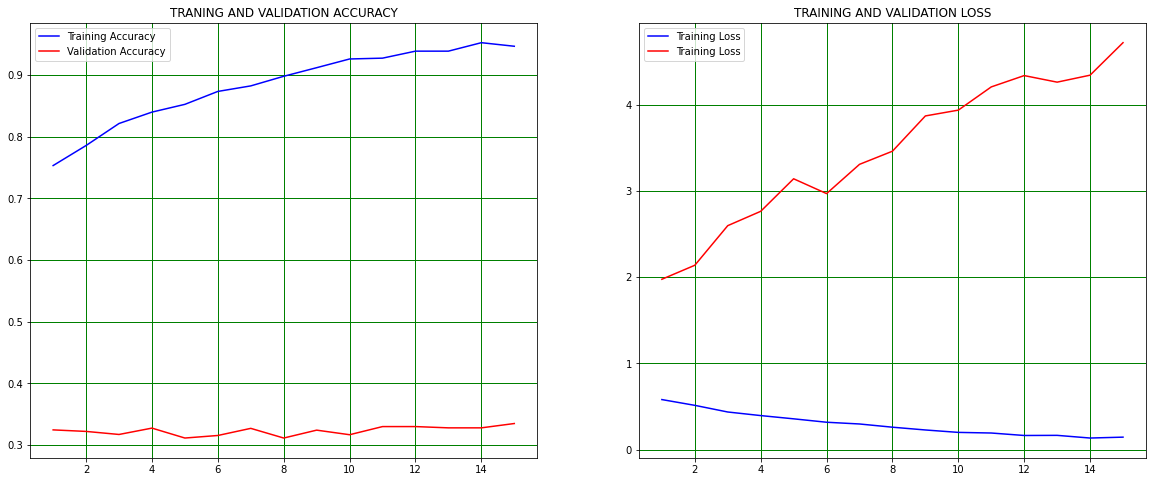

In [ ]:
# Train and visualize
History = model.fit(train_config, train_translated.label.values, epochs = 15, verbose = 1, batch_size = 64, validation_split = 0.2)
plot_history(History)

In [ ]:
# Predict test set
predictions = [np.argmax(i) for i in model.predict(test_config)]
test_translated = test_translated.drop(columns=['lang_abv', 'language','cleaned_premise', 'cleaned_hypothesis'])
test_translated['prediction'] = predictions
test_translated.head()

,id,premise,hypothesis,prediction
0,aa2510d454,His family had lost a son and a daughter now.,The son and daughter had lost their father.,2
1,865d1c7b16,Steps are initiated to allow program board mem...,There's enough room for 35-40 positions on the...,0
2,6d9fa191e6,"agencies' operating trust, enterprise and inte...",Agencies in financial trouble are usually audi...,1
3,f11f1ffffe,how long has he been in his present position,What length of time has he held the current po...,2
4,40a9b0f08e,Research and development is composed of,R&D is made up of.,0


> **Conclusion:**

> The model has high accuracy (84%), but the accuracy of the validation set is almost constant.

> Loss of train set decreases but validation set increases.